# Анализ связи ключевых показателей игровой статистики с успешностью команды в профессиональном Counter-Strike

*Во всей работе я постараюсь по возможности опускать неинтересные читателю сущностные аспекты темы, оставляя пояснения лишь там, где они необходимы для понимания аналитической части.*

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# О данных

Подгружаем данные из таблицы в репозитории.

In [2]:
data = pd.read_csv('https://github.com/Utukku/DataAnalysisProject/raw/refs/heads/main/dataset.csv')

In [3]:
data.head()

,winrate,opening_kills,multikills,5v4,4v5,trades,grenades_damage,flash_assists,pistol_wins,r2_conversion,r2_break
0,60.4,55.0,0.95,80.8,35.6,24.1,18.0,0.22,50.0,87.5,50.0
1,56.7,53.1,0.94,74.6,36.5,26.4,11.0,0.19,65.4,70.6,44.4
2,56.3,53.3,0.92,77.4,32.4,23.0,17.3,0.24,48.6,88.9,21.1
3,56.0,52.9,0.92,78.4,30.8,21.9,22.7,0.15,46.9,73.3,17.6
4,55.8,59.4,0.96,75.6,26.8,20.7,21.8,0.20,50.0,84.6,38.5


Во всех столбцах содержатся количественные показатели команд за некоторый месяц. То есть каждая запись это статистика какой-то команды за какой-то месяц. Конкретика в рамках этой работы значения не имеет, поскольку цель состоит в выяснении взаимосвязей самих показателей. Поскольку данные попадают в источник, только если у команды вообще были матчи за месяц, пропусков в данных нет. Это нам очень удобно, не надо будет думать над их заполнением. Все показатели, кроме multikills, flash_assists и grenades_damage даны в процентах, то есть их значения от 0 до 100. Значения multikills, flash_assists и grenades_damage абсолютные, не меньше 0.

Взглянем на описание таблицы:

In [4]:
data.describe()

,winrate,opening_kills,multikills,5v4,4v5,trades,grenades_damage,flash_assists,pistol_wins,r2_conversion,r2_break
count,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000
mean,51.287242,50.656828,0.816246,72.930333,29.064809,20.193835,22.311472,0.227367,51.119882,81.030067,20.427842
std,3.898968,3.009935,0.050765,3.603081,3.735415,1.697654,4.190656,0.048090,7.965897,9.429476,10.528895
min,32.000000,38.600000,0.630000,53.500000,12.300000,13.900000,9.700000,0.050000,14.700000,33.300000,0.000000
25%,48.800000,48.700000,0.780000,70.700000,26.600000,19.100000,19.400000,0.190000,45.800000,75.000000,13.000000
50%,51.200000,50.600000,0.810000,73.000000,29.000000,20.100000,22.100000,0.220000,50.000000,81.800000,20.000000
75%,53.600000,52.600000,0.850000,75.200000,31.300000,21.200000,25.000000,0.260000,56.200000,87.500000,27.300000
max,70.100000,63.100000,1.060000,88.300000,47.900000,26.900000,39.900000,0.500000,83.300000,100.000000,61.500000


# EDA, создание новых признаков и проверка гипотез

Сразу добавим один нужный для дальнейшего анализа признак. Это среднее количество выигранных раундов из первых двух. Это не единственный показатель, который мы добавим в исходный датасет, остальные появятся дальше.

In [36]:
data['two_rounds'] = data.pistol_wins * data.r2_conversion / 10000 * 2 + (100 - data.pistol_wins) * data.r2_break / 10000 + data.pistol_wins * (100 - data.r2_conversion) / 10000
data.head()

,winrate,opening_kills,multikills,5v4,4v5,trades,grenades_damage,flash_assists,pistol_wins,r2_conversion,r2_break,opening_surplus,two_rounds
0,60.4,55.0,0.95,80.8,35.6,24.1,18.0,0.22,50.0,87.5,50.0,-5.4,1.187500
1,56.7,53.1,0.94,74.6,36.5,26.4,11.0,0.19,65.4,70.6,44.4,-3.6,1.269348
2,56.3,53.3,0.92,77.4,32.4,23.0,17.3,0.24,48.6,88.9,21.1,-3.0,1.026508
3,56.0,52.9,0.92,78.4,30.8,21.9,22.7,0.15,46.9,73.3,17.6,-3.1,0.906233
4,55.8,59.4,0.96,75.6,26.8,20.7,21.8,0.20,50.0,84.6,38.5,3.6,1.115500


Для начала посмотрим на простые визуализации взаимосвязей нескольких столбцов.

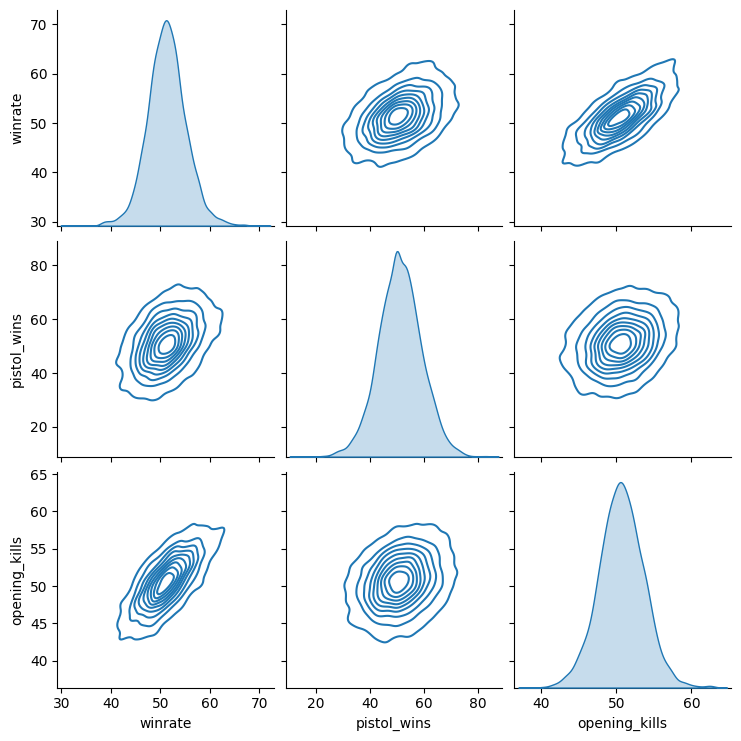

In [28]:
columns = ['winrate', 'pistol_wins', 'opening_kills']
sns.pairplot(data[columns], kind='kde');

Совместное распределение для **winrate** и **pistol_wins** вытягивается в подобие диагонального овала, свидетельствующее о вероятной корреляции. Она есть, но не слишком впечатляющая:

In [35]:
np.corrcoef(data.pistol_wins, data.winrate)[0][1]

0.41548761340515666

Кажется, будто матожидания могут быть где-то очень рядом. Поглядим на распределение разности этих двух показателей:

In [49]:
data['pistol_surplus'] = data.pistol_wins - data.winrate

Посмотрим, как это выглядит:

<Axes: xlabel='Percent difference', ylabel='Density'>

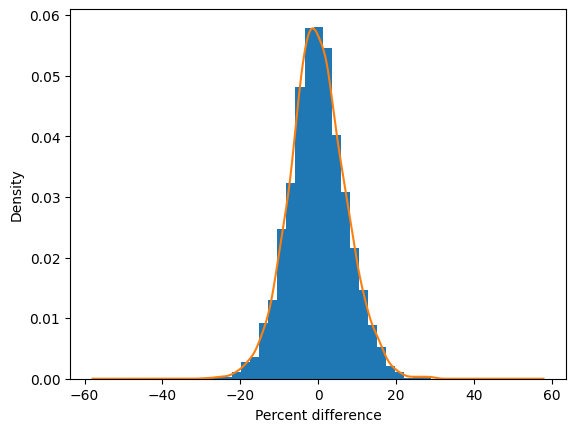

In [50]:
plt.hist(data.pistol_surplus, density=True, bins=25)
plt.xlabel('Percent difference')
data.pistol_surplus.plot(kind='kde')

Что-то с центром около нуля. Применим t-критерий Стьюдента, чтобы проверить это при уровне значимости 5%. Необходимые предпосылки его применения тут выполенены: выборочные средние распределены нормально.

In [ ]:
alpha = 0.05
n = len(data.winrate)
diffs = data.winrate - data.pistol_wins
diff_mean = diffs.mean()
diff_std = diffs.std()
rat = diff_mean / (diff_std / np.sqrt(n))
crit = scipy.stats.t.ppf(1 - alpha / 2, df=n) # при такой выборке можно было использовать нормальное, но для наглядности оставим собственно Стьюдента
abs(rat) < crit

True

Ого! Выходит, не отвергаем гипотезу об одинаковом математическом ожидании доли побед в первых раундах и раундах вообще. Это вовсе не тривиально: игровой процесс здорово отличается в первых раундах.

Ещё ярче вероятная корреляция для winrate и opening_kills. Проделаем то же самое для этих показателей:

In [29]:
np.corrcoef(data.opening_kills, data.winrate)[0][1]

0.718355828494599

Тоже кажется, будто матожидания могут быть где-то очень рядом. Поглядим на распределение разности:

In [30]:
data['opening_surplus'] = data.opening_kills - data.winrate

Посмотрим, как это выглядит:

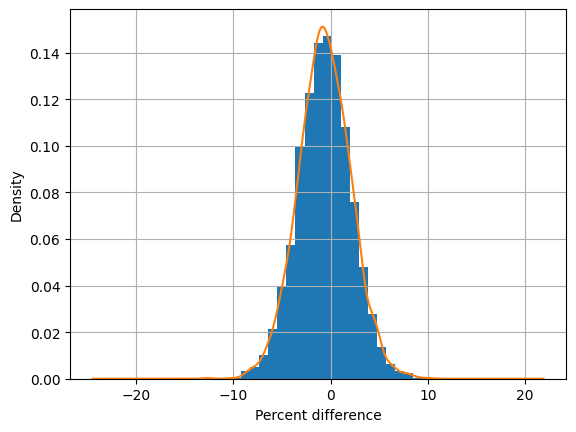

In [47]:
plt.hist(data.opening_surplus, density=True, bins=25)
data.opening_surplus.plot(kind='kde')
plt.xlabel('Percent difference')
plt.grid()

Тоже что-то с центром около нуля. Снова применим t-критерий Стьюдента, чтобы проверить это при уровне значимости 5%.

In [33]:
alpha = 0.01
n = len(data.winrate)
diffs = data.winrate - data.opening_surplus
diff_mean = diffs.mean()
diff_std = diffs.std()
rat = diff_mean / (diff_std / np.sqrt(n))
crit = scipy.stats.t.ppf(1 - alpha / 2, df=n)
abs(rat) < crit

False

А вот тут нет! Отвергаем гипотезу об одинаковом математическом ожидании доли побед в раундах и доли первых убийств.



---



Теперь посмотрим пристальнее на доли выигранных раундов в меньшинстве и в большинстве.

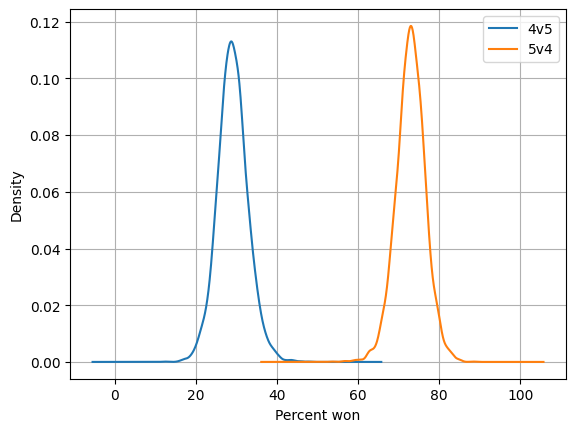

In [16]:
data['4v5'].plot(kind='kde', label='4v5')
data['5v4'].plot(kind='kde', label='5v4')
plt.xlabel('Percent won')
plt.grid()
plt.legend()

Кажется, что их распределения одинаковы, только смещены друг относительно друга. Попробуем проверить (скорее, конечно, опровергнуть) это F-тестом дисперсий.

In [27]:
alpha = 0.01
n = len(data.winrate)
var1 = data['4v5'].std() ** 2
var2 = data['5v4'].std() ** 2
rat = var1 / var2
crit1 = scipy.stats.f.ppf(alpha / 2, dfn=n, dfd=n)
crit2 = scipy.stats.f.ppf(1 - alpha / 2, dfn=n, dfd=n)
crit1 < rat < crit2

True

Вот! Не отвергаем. Правда, только при таком уровне значимости. Если его повысить, гипотеза развалится.

Теперь проделаем то же самое с долями побед во втором раунде после проигранного и выигранного первого.

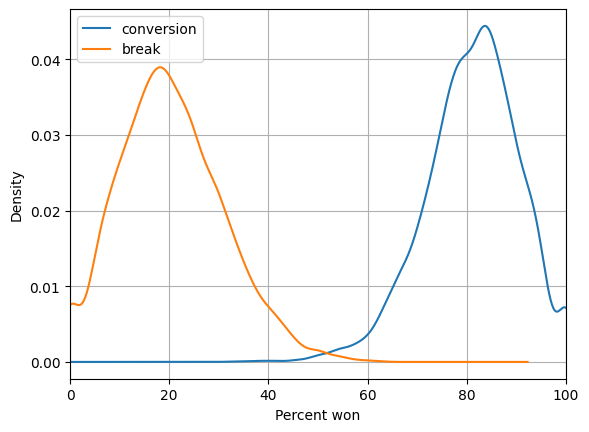

In [21]:
data.r2_conversion.plot(kind='kde', label='conversion')
data.r2_break.plot(kind='kde', label='break')
plt.xlabel('Percent won')
plt.gca().set_xlim([0, 100])
plt.grid()
plt.legend()

Вновь кажется, что распределения похожи, только смещены.

In [26]:
alpha = 0.01
n = len(data.winrate)
var1 = data.r2_conversion.std() ** 2
var2 = data.r2_break.std() ** 2
rat = var1 / var2
crit1 = scipy.stats.f.ppf(alpha / 2, dfn=n, dfd=n)
crit2 = scipy.stats.f.ppf(1 - alpha / 2, dfn=n, dfd=n)
print(crit1, rat, crit2)
crit1 < rat < crit2

0.9290295819015694 0.8020650224979616 1.0763919895351082


False

А вот тут не вышло. При адекватных уровнях значимости гипотезу отвергаем.

# Машинное обучение

Напоследок немного развлечёмся с простеньким машинным обучением. Попробуем спрогнозировать **winrate** по части остальных данных. В качестве объясняющих переменных будем использовать все столбцы исходной таблицы, кроме **4v5** и **5v4** - они слишком уж похожи на то, что собираемся предсказывать, использовать их неинтересно.

Для начала зададим метрики — будем выводить среднее абсолютное отклонение, среднее квадратическое отклонение и отклонение в процентах. Посмотрим на все три, может быть, и выбирать из них не нужно будет.

In [43]:
def print_metrics(y_test,y_pred):
    print('MAE:', "%.4f" % sklearn.metrics.mean_absolute_error(y_test, y_pred))
    print('RMSE:', "%.4f" % np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred)))
    print('MAPE:', "%.4f" % sklearn.metrics.mean_absolute_percentage_error(y_test,y_pred))

Для начала оценим наивно: просто средним.

In [44]:
columns = ['winrate', 'multikills', 'opening_kills', 'trades', 'pistol_wins', 'flash_assists', 'grenades_damage', 'two_rounds']
data_train, data_test = sklearn.model_selection.train_test_split(data[columns], test_size = 0.25)
y_train = data_train['winrate'].to_numpy()
y_test = data_test['winrate'].to_numpy()


y_pred_regr = np.ones(len(y_test)) * y_train.mean()
print_metrics(y_test, y_pred_regr)

MAE: 2.9557
RMSE: 3.8687
MAPE: 0.0581


Теперь построим прогноз линейной регрессией.

In [45]:
columns = ['winrate', 'multikills', 'opening_kills', 'trades', 'pistol_wins', 'flash_assists', 'grenades_damage', 'two_rounds']
data_train, data_test = sklearn.model_selection.train_test_split(data[columns], test_size = 0.25)
y_train = data_train['winrate'].to_numpy()
y_test = data_test['winrate'].to_numpy()

X_train = data_train.drop('winrate', axis=1).to_numpy()
X_test = data_test.drop('winrate', axis=1).to_numpy()

model_regression = sklearn.linear_model.LinearRegression()

model_regression.fit(X_train, y_train)

y_pred_regr = model_regression.predict(X_test)
print_metrics(y_test, y_pred_regr)

MAE: 1.4209
RMSE: 1.8095
MAPE: 0.0280


Видно, что все метрики здорово сократились, то есть прогноз стал значительно точнее. Невеликое достижение, но хорошо.

Попробуем добиться лучшего результата с помощью KNN с подбором гиперпараметра.

In [41]:
columns = ['winrate', 'multikills', 'opening_kills', 'trades', 'pistol_wins', 'flash_assists', 'grenades_damage', 'two_rounds']
data_train, data_test = sklearn.model_selection.train_test_split(data[columns], test_size = 0.25)
y_train = data_train['winrate'].to_numpy()
y_test = data_test['winrate'].to_numpy()

X_train = data_train.drop('winrate', axis=1).to_numpy()
X_test = data_test.drop('winrate', axis=1).to_numpy()

scaler = sklearn.preprocessing.StandardScaler()

X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

nn_min = 0
min_metric = 3

for nn in range(1, 100):

    model_knn = sklearn.neighbors.KNeighborsRegressor(n_neighbors=nn)

    model_knn.fit(X_train, y_train)

    y_pred_knn = model_knn.predict(X_test)

    metric = sklearn.metrics.mean_absolute_percentage_error(y_test,y_pred_knn)

    if metric < min_metric:

        nn_min = nn

        min_metric = metric

print(nn_min, min_metric)

35 0.03824534945460066


Увы! Даже с лучшим гиперпараметром KNN-прогноз работает хуже, чем банальная линейная регрессия. Очевидно, эта задача прогнозирования потребовала бы более продвинутых средств для эффективного решения. Оставим это всем заинтересованным — мой дедлайн уже близко.